# Group Invariant Convolutional Network
In this project I will develop a Convolutional Neural Network that is invariant (or at least as much as possible) to the actions of a symmetry group. In particular I will consider the cyclic group C4, that includes the four rotation symmetries of a square and the dihedral group D4, that includes all the rotation and reflection symmetries of a square. The Convolutional Neural Network will learn a classification function that should be invariant to the group actions. To test the invariance I trained the network on the famous FashionMNIST dataset and I augmented only the testset by applying at random actions from the chosen group.

## Dihedral Group D4
In this section I will explain the class `DihedralGroup`, that implement the action of the group applied on the R2 grid as well as the composition of group actions.

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from groupconv.groups import *
from groupconv.conv import *
import matplotlib.pyplot as plt

The class `DihedralGroup` implements the actions of the DihedralGroup, that is the symmetry group of rotations and reflections of a regular polygon with n vertices. For this reason the constructor needs the number of vertices of the polygon. In the network implementation I will restrict to the d4 group (symmetries of a square) in order to not introduce interpolation artifacts. However I implemented the DihedralGroup parametric in the number of vertices, hence the group can be instantiated for any regular polygon, and if the coordinates of the transformed grid do not end up into integer coordinates the resulting pixel is interpolated.

In [2]:
c4 = CyclicGroup(4)
rot0, rot1, rot2, rot3,  = c4.elements()

In [3]:
img = Image.open("images/bitmap.png").convert('RGB')
img_tensor = transforms.ToTensor()(img)
img_tensor.shape

torch.Size([3, 547, 547])

In [4]:
# This creates a grid of the pixel locations in our image, normalized in the range [-1,1]
img_grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    torch.linspace(-1, 1, img_tensor.shape[-2]),
))
img_grid_R2.shape

/home/giorgio/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2, 547, 547])

The method `left_action_on_R2` takes a batch of group actions and a 2D grid and apply each action to the grid.

In [5]:
actions = torch.stack([rot0, rot1, rot2, rot3],dim=0)
transformed_grid = c4.left_action_on_R2(actions,img_grid_R2)
transformed_grid.shape

torch.Size([4, 547, 547, 2])

In [6]:
# Given an input and a grid, computes the output using input values and pixel locations from grid.
# Grid and input are expected to have same batch size, hence we repeat the img_tensor for each action
# along the first axis.
img_tensor = img_tensor.unsqueeze(0).repeat(4,1,1,1)
transformed_imgs = torch.nn.functional.grid_sample(img_tensor,transformed_grid,align_corners=True, mode="bilinear")
transformed_imgs.shape

torch.Size([4, 3, 547, 547])

The following figure shows the effects of all the 8 actions on an image. In the first row we see all the rotations, and in particular from left to right:
- 0 degrees (identity)
- 90 degrees
- 180 degrees
- 270 degrees

While on the second row the effects of the reflections are shown. From left to right:
- reflection along vertical axis
- reflection along first diagonal
- reflection along horizontal axis
- reflection along second diagonal

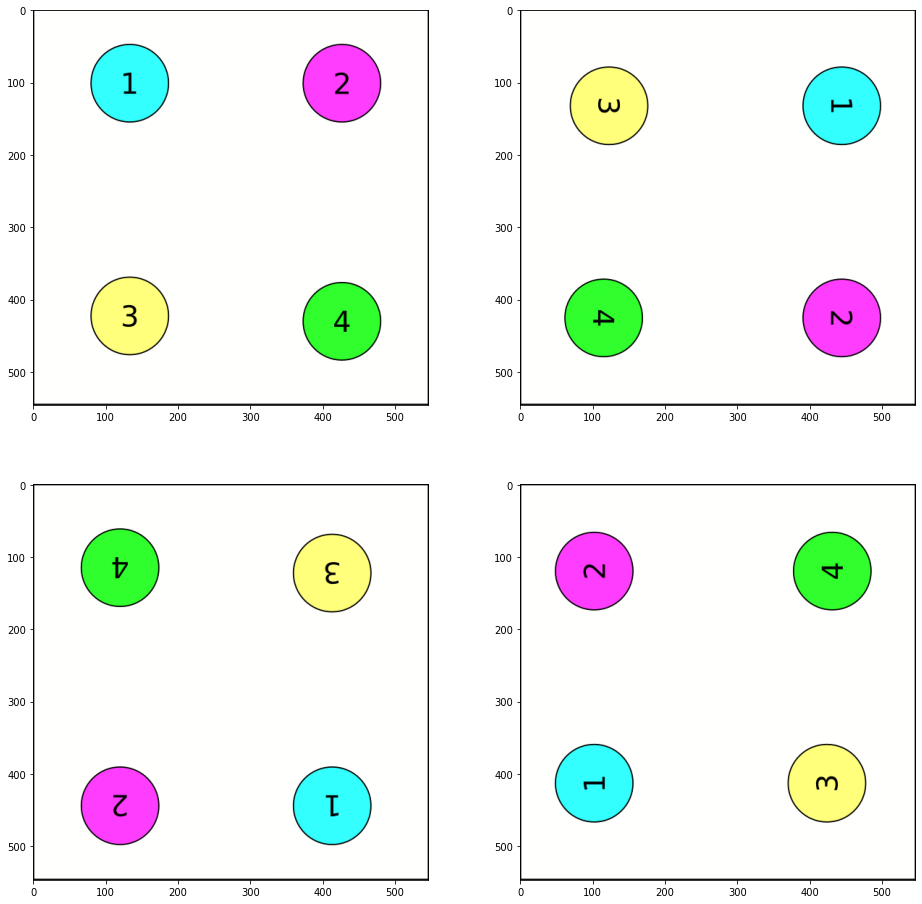

In [7]:
transformed_imgs_chlast = torch.einsum("bchw->bhwc",transformed_imgs)
fig,axes = plt.subplots(2,2)
fig.set_size_inches(16,16)
for i,ax in enumerate(axes.flat):
    ax.imshow(transformed_imgs_chlast[i])
plt.show()


## Group Equivariant Convolution
In this section we will discuss the Group Equivariant Convolution and its implementation.

### From Convolution to Group Equivariant Convolution
Let us first write down the equation of the standard convolution. For simplicity let us assume just one input channel and one output channel:
$$
o[\tau] = (x[t] \ast k[t])[\tau] = \sum_{i\in{Z^2}} x[i]k[i-\tau]
$$
We know that the convolution operator is translation equivariant, meaning that:
$$
(x[t-t'] \ast k[t])[\tau] = \sum_{i\in{Z^2}} x[i-t']k[i-\tau] = o[\tau-t']
$$
We can think of the convolution operator as a function of the elements of a group, and in particular the translation group $\mathcal{T}$.
With that in mind, we can now generalize the convolution operator to a generic group $\mathcal{G}$ as follows:
$$
o[g] = \sum_{i\in{Z^2}} x[i] g(k[i])
$$
Where $g$ is an action of the group $\mathcal{G}$.
In our case $\mathcal{G}$ is the group of symmetryes (translations, rotations and reflections) of a square, and it will be decomposed into the translation group $\mathcal{T}$ and the dihedral group D4.

### Lifting Convolution
We need to make a distintion between the first convolution and the other convolutions. In the first convolution the feature map is a function on $Z^2$, while in the other convolution the feature map is a function on G. Hence the first convolution (or Lifting Convolution) is defined as:
$$
o[g\in G] =  \sum_{i\in{Z^2}}x[i]g(k[i])
$$

In [8]:
kernel_weights = Image.open("images/bitmap.png").convert('L')
kernel_weights = transforms.ToTensor()(kernel_weights)[0,...]
kernel_weights.shape

torch.Size([547, 547])

In [9]:
lift_conv = LiftingConvolution(group=c4,in_channels=1,out_channels=1,kernel_size=547)
lift_conv.kernel.weight.data = kernel_weights.unsqueeze(0).unsqueeze(0)
lift_conv.kernel.weight.data.shape

torch.Size([1, 1, 547, 547])

In [10]:
kernels = lift_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 4, 1, 547, 547])

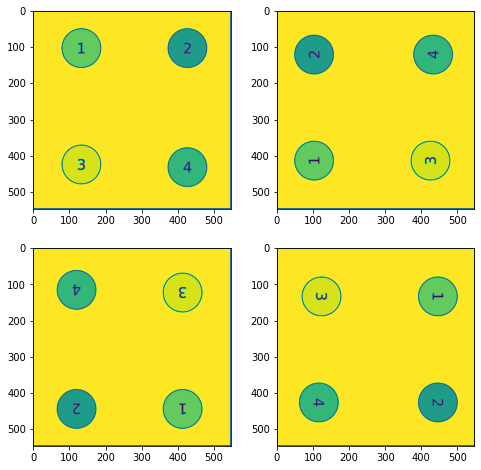

In [11]:
fig,axes = plt.subplots(2,2)
fig.set_size_inches(8,8)
for i,ax in enumerate(axes.flat):
    ax.imshow(kernels[0,i,0,...])
plt.show()

### General Convolution
In the other layers the feature map is a function on G hence the convolution becomes:
$$
o[g\in G] = \sum_{g'\in G} x[g'] g(k[g'])
$$

In [12]:
group_conv = GroupConvolution(group=c4,in_channels=1,out_channels=1,kernel_size=547)
group_conv.kernel.weight.data = torch.einsum("abcde->acbde",kernels)

In [13]:
kernels = group_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 4, 1, 4, 547, 547])

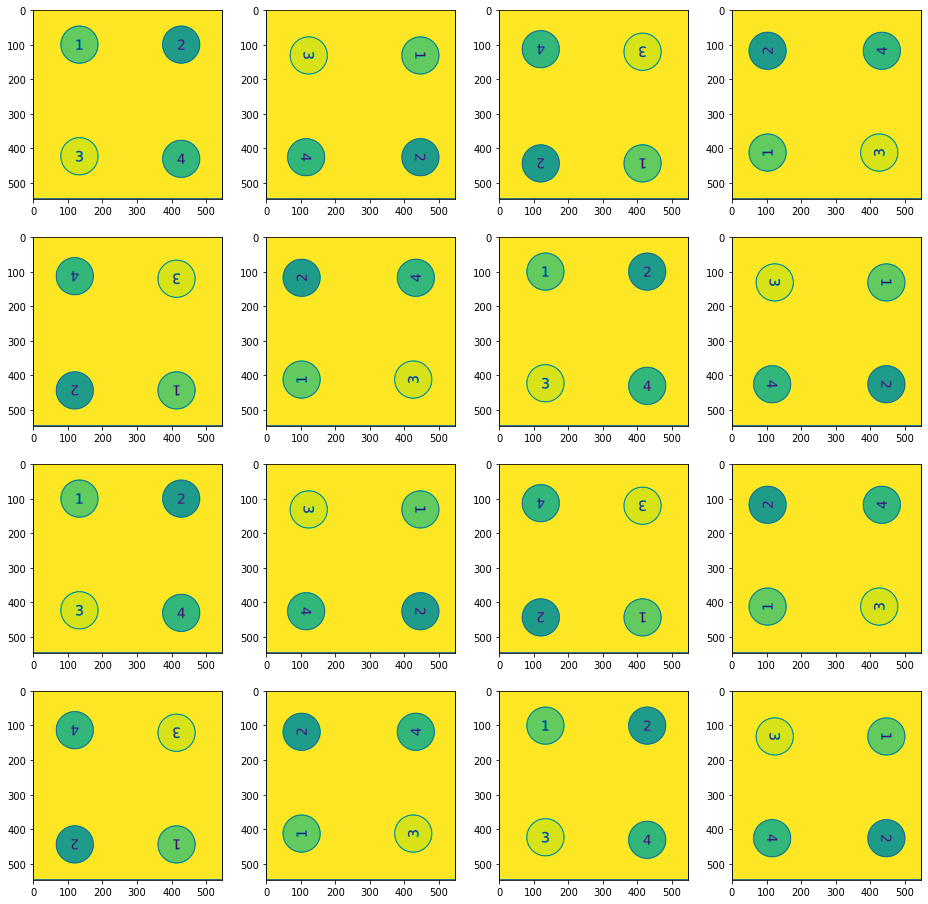

In [68]:
fig,axes = plt.subplots(4,4)
fig.set_size_inches(16,16)
g_idx = 0
for g_idx in range(4):
    for g_p_idx in range(4):
        axes[g_idx,g_p_idx].imshow(kernels[0,g_idx,0,g_p_idx,...])
plt.show()

## Bibliography
- Cohen, Taco, and Max Welling. "Group equivariant convolutional networks." International conference on machine learning. PMLR, 2016.
